In [8]:
# copyright: https://github.com/konosp/propensity-score-matching/blob/main/propensity_score_matching_v2.ipynb
# for personal study purposes only


- X: confounders (age, fare)
- T: treatment (hasCabin)
- y: survived indicator

- Want to see whether hasCabin affects survival probability
    - But treatment assignment is not random, potentially determined by X, which also affects y

- Basically
    - survived = hasCabin + $\epsilon$
    - $\epsilon$ = $\epsilon$(X) is correlated with hasCabin


- What does matching do:
    - Control for X
    - Find two groups of people, group 1 has T = 0, group 2 has T = 1, group1[i] and group2[i] have similar X values
    - Then we can just compare y1[i] and y2[i] to figure out the effect of T alone

In [9]:
import math
import numpy as np
import pandas as pd
# import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics


In [11]:
import math
import pandas as pd

def perform_match_exact(row, df , *args):
    # row is the the item that we want to match
    # df is the source Pandas dataframe that we want to match it with other items
    # print('Start matching')
    sub_set = df
    
    for arg in args:
        sub_set = sub_set.loc[sub_set[arg] == row[arg]]
        # print(sub_set)
        
    return sub_set.index


def logit(p):
    logit_value = math.log(p / (1-p))
    return logit_value

def hasCabin(x):
    if pd.isna(x):
        return 0
    else:
        return 1
    
def cohenD (tmp, metricName):
    treated_metric = tmp[tmp.treatment == 1][metricName]
    untreated_metric = tmp[tmp.treatment == 0][metricName]
    
    d = ( treated_metric.mean() - untreated_metric.mean() ) / math.sqrt(((treated_metric.count()-1)*treated_metric.std()**2 + (untreated_metric.count()-1)*untreated_metric.std()**2) / (treated_metric.count() + untreated_metric.count()-2))
    return d

In [30]:
df = pd.read_csv('train.csv')

df = df[~df.Age.isna()]
df = df[~df.Embarked.isna()]
df = df.reset_index()
y = df[['Survived']]
df = df.drop(columns = ['Survived'])

df['treatment'] = df.Cabin.apply(hasCabin)


df = df[['treatment','Sex','Age','SibSp','Parch','Embarked', 'Pclass', 'Fare']]



T = df['treatment']
X = df.drop('treatment', axis = 1)
X_encoded = pd.get_dummies(
    X,
    columns = ['Sex','Embarked', 'Pclass'], 
    prefix = {'Sex':'sex', 'Embarked' : 'embarked', 'Pclass' : 'class'}, 
    drop_first=False,
)

X_encoded = pd.DataFrame(
    data = StandardScaler().fit_transform(X_encoded),
    columns = X_encoded.columns,
)

In [31]:
X_encoded.head()

,Age,SibSp,Parch,Fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,class_1,class_2,class_3
0,-0.527669,0.522511,-0.506787,-0.516380,-0.756138,0.756138,-0.472618,-0.202326,0.534040,-0.590326,-0.566538,1.002813
1,0.577094,0.522511,-0.506787,0.694046,1.322511,-1.322511,2.115874,-0.202326,-1.872519,1.693979,-0.566538,-0.997195
2,-0.251478,-0.552714,-0.506787,-0.503620,1.322511,-1.322511,-0.472618,-0.202326,0.534040,-0.590326,-0.566538,1.002813
3,0.369951,0.522511,-0.506787,0.350326,1.322511,-1.322511,-0.472618,-0.202326,0.534040,1.693979,-0.566538,-0.997195
4,0.369951,-0.552714,-0.506787,-0.501257,-0.756138,0.756138,-0.472618,-0.202326,0.534040,-0.590326,-0.566538,1.002813


0.9283707865168539
[[503  26]
 [ 25 158]]
0.8610354223433242


Compare T = 0 vs T = 1: propensity distribution is quite different
This suggests the X distribution is quite different
Hence a blind comparison of E[Y|T=1] and E[Y|T=0] will pick up lots of effect from X


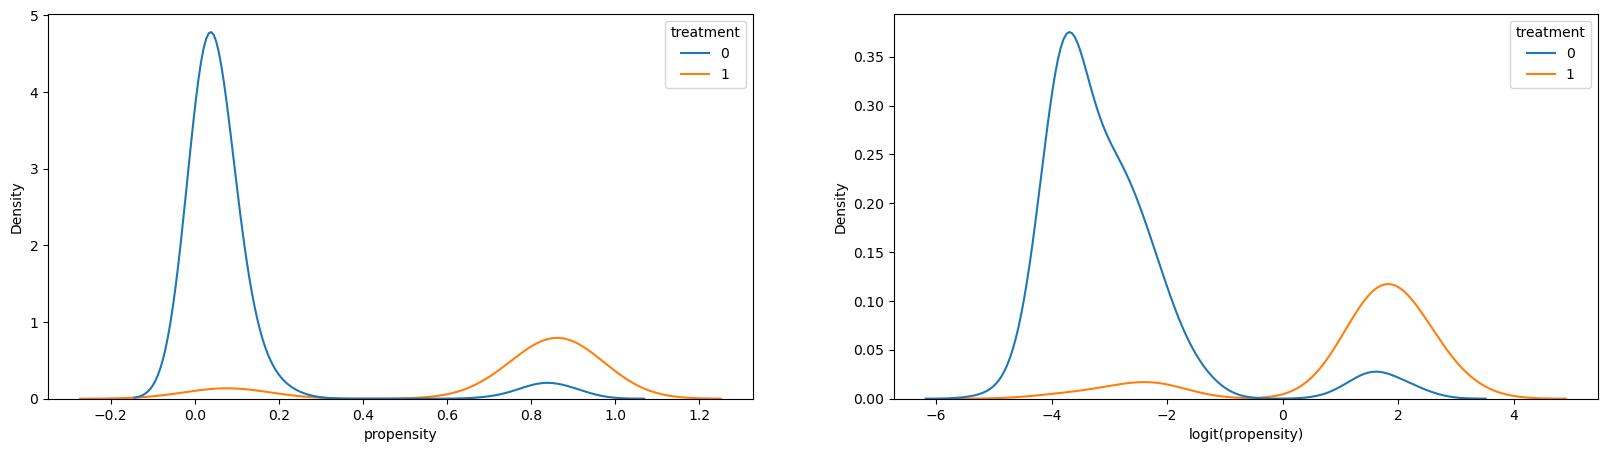

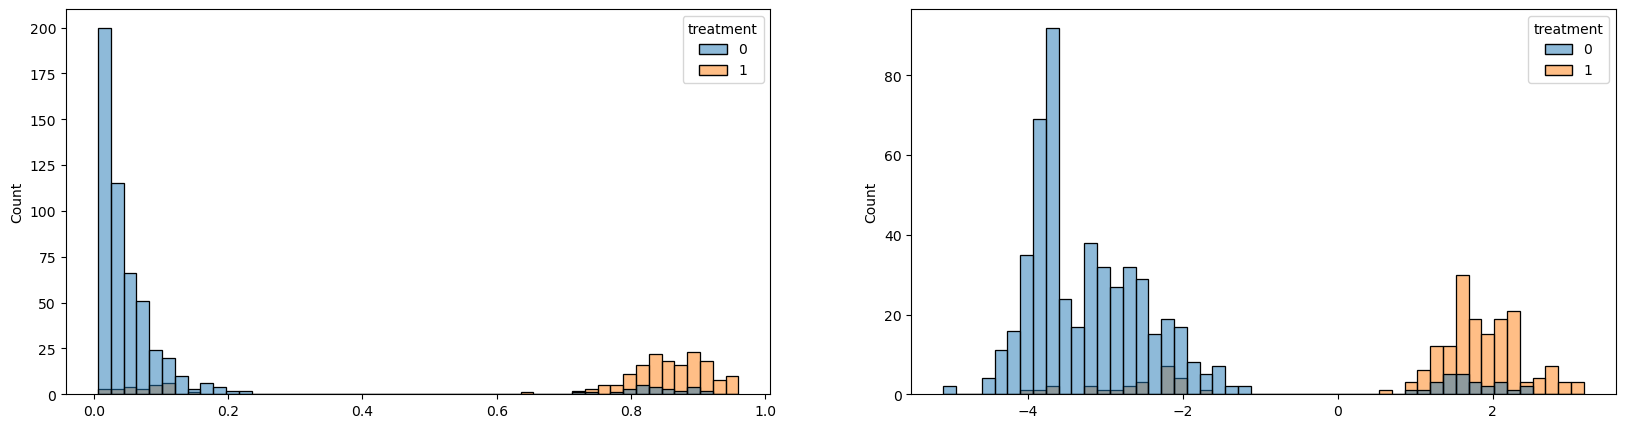

In [32]:
# propensity estimate
lr = LogisticRegression().fit(X_encoded, T)

predictions = lr.predict_proba(X_encoded)
predictions_binary = lr.predict(X_encoded)
predictions_logit = np.array([logit(x) for x in predictions[:, 1]])


X_encoded['propensity_score'] = predictions[:,1]
X_encoded['propensity_score_logit'] = predictions_logit
X_encoded['outcome'] = y.Survived
X_encoded['treatment'] = df['treatment']




# how well is propensity estimate
print(metrics.accuracy_score(T, predictions_binary))
print(metrics.confusion_matrix(T, predictions_binary))
print(metrics.f1_score(T, predictions_binary))

fig, ax = plt.subplots(1, 2, figsize = (20, 5))
sns.kdeplot(x = predictions[:, 1], hue = T, ax = ax[0])
sns.kdeplot(x = predictions_logit, hue = T, ax = ax[1])
ax[0].set_xlabel('propensity')
ax[1].set_xlabel('logit(propensity)')
print('\n\nCompare T = 0 vs T = 1: propensity distribution is quite different\nThis suggests the X distribution is quite different\nHence a blind comparison of E[Y|T=1] and E[Y|T=0] will pick up lots of effect from X')
plt.show()

fig, ax = plt.subplots(1, 2, figsize = (20, 5))
sns.histplot(x = predictions[:, 1], hue = T, bins = 50, ax = ax[0])
sns.histplot(x = predictions_logit, hue = T, bins = 50, ax = ax[1])
plt.show()

In [33]:
X_encoded.head()

,Age,SibSp,Parch,Fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,class_1,class_2,class_3,propensity_score,propensity_score_logit,outcome,treatment
0,-0.527669,0.522511,-0.506787,-0.516380,-0.756138,0.756138,-0.472618,-0.202326,0.534040,-0.590326,-0.566538,1.002813,0.021156,-3.834463,0,0
1,0.577094,0.522511,-0.506787,0.694046,1.322511,-1.322511,2.115874,-0.202326,-1.872519,1.693979,-0.566538,-0.997195,0.866755,1.872566,1,1
2,-0.251478,-0.552714,-0.506787,-0.503620,1.322511,-1.322511,-0.472618,-0.202326,0.534040,-0.590326,-0.566538,1.002813,0.039982,-3.178512,1,0
3,0.369951,0.522511,-0.506787,0.350326,1.322511,-1.322511,-0.472618,-0.202326,0.534040,1.693979,-0.566538,-0.997195,0.895107,2.144005,1,1
4,0.369951,-0.552714,-0.506787,-0.501257,-0.756138,0.756138,-0.472618,-0.202326,0.534040,-0.590326,-0.566538,1.002813,0.019913,-3.896294,0,0


## Matching

In [34]:
caliper = np.std(
    X_encoded['propensity_score']
) * 0.25

print(f'caliper = {caliper}')



caliper = 0.08890268148266277


In [38]:
# find the 10 nearest neighbors of each observation i (based on propensity score), with a max distance of caliper

knn = NearestNeighbors(
    n_neighbors = 10,
    p = 2,
    radius = caliper,
).fit(
    X_encoded[['propensity_score_logit']]
)

In [39]:
# knn.kneighbors(X, n_neighbors): find the n_neighbors nearest points around X, kinda like predict method

distances, indexes = knn.kneighbors(
    X_encoded[['propensity_score_logit']],
    n_neighbors = 10,
)

In [43]:
i = 0
print(f'''find 10 nearest points of index {i} with propensity score logit = {X_encoded.loc[i]['propensity_score_logit']}''')
for j, d in zip(indexes[i], distances[i]):
    print(f'''index = {j}, propensity score logit = {X_encoded.loc[j]['propensity_score_logit']}, distance = {d}''')

find 10 nearest points of index 0 with propensity score logit = -3.8344632263321987
index = 0, propensity score logit = -3.8344632263321987, distance = 0.0
index = 607, propensity score logit = -3.8344418946088172, distance = 2.133172338147915e-05
index = 539, propensity score logit = -3.8355690241771567, distance = 0.001105797844958012
index = 301, propensity score logit = -3.8299728363663306, distance = 0.004490389965868147
index = 590, propensity score logit = -3.8279230375689925, distance = 0.006540188763206167
index = 641, propensity score logit = -3.8277146380488714, distance = 0.006748588283327361
index = 611, propensity score logit = -3.8415813913864465, distance = 0.0071181650542477826
index = 36, propensity score logit = -3.825918309801798, distance = 0.00854491653040057
index = 134, propensity score logit = -3.8442558210880597, distance = 0.009792594755861028
index = 449, propensity score logit = -3.8448740371822274, distance = 0.010410810850028707


In [47]:
# now we are ready to perform matching
# for each row i in X_encoded with T = 1, we figure what the propensity_score_logit is, then we loop over indexes[i] to find a point that: 
# (1) is not i itself
# (2) has T = 0
# (3) is closest to i (basically is the lowest index in indexes[i])

def perform_matching(row):

    i = row.name # current index

    if row['treatment'] == 0:
        return np.nan
    for j in indexes[i]:
        if j != i and X_encoded.loc[j]['treatment'] == 0:
            return j
    return np.nan

X_encoded['matched_element'] = X_encoded.apply(perform_matching, axis = 1)

In [48]:
X_encoded

,Age,SibSp,Parch,Fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,class_1,class_2,class_3,propensity_score,propensity_score_logit,outcome,treatment,matched_element
0,-0.527669,0.522511,-0.506787,-0.516380,-0.756138,0.756138,-0.472618,-0.202326,0.534040,-0.590326,-0.566538,1.002813,0.021156,-3.834463,0,0,NaN
1,0.577094,0.522511,-0.506787,0.694046,1.322511,-1.322511,2.115874,-0.202326,-1.872519,1.693979,-0.566538,-0.997195,0.866755,1.872566,1,1,62.0
2,-0.251478,-0.552714,-0.506787,-0.503620,1.322511,-1.322511,-0.472618,-0.202326,0.534040,-0.590326,-0.566538,1.002813,0.039982,-3.178512,1,0,NaN
3,0.369951,0.522511,-0.506787,0.350326,1.322511,-1.322511,-0.472618,-0.202326,0.534040,1.693979,-0.566538,-0.997195,0.895107,2.144005,1,1,306.0
4,0.369951,-0.552714,-0.506787,-0.501257,-0.756138,0.756138,-0.472618,-0.202326,0.534040,-0.590326,-0.566538,1.002813,0.019913,-3.896294,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,0.646142,-0.552714,5.350885,-0.102875,1.322511,-1.322511,-0.472618,4.942527,-1.872519,-0.590326,-0.566538,1.002813,0.068306,-2.613010,0,0,NaN
708,-0.182430,-0.552714,-0.506787,-0.407687,-0.756138,0.756138,-0.472618,-0.202326,0.534040,-0.590326,1.765108,-0.997195,0.066783,-2.637188,0,0,NaN
709,-0.734812,-0.552714,-0.506787,-0.086335,1.322511,-1.322511,-0.472618,-0.202326,0.534040,1.693979,-0.566538,-0.997195,0.931490,2.609811,1,1,NaN
710,-0.251478,-0.552714,-0.506787,-0.086335,-0.756138,0.756138,2.115874,-0.202326,-1.872519,1.693979,-0.566538,-0.997195,0.849575,1.731272,1,1,303.0


In [49]:
treated_matched_data  = X_encoded.query('~matched_element.isna()')
treated_matched_data

,Age,SibSp,Parch,Fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,class_1,class_2,class_3,propensity_score,propensity_score_logit,outcome,treatment,matched_element
1,0.577094,0.522511,-0.506787,0.694046,1.322511,-1.322511,2.115874,-0.202326,-1.872519,1.693979,-0.566538,-0.997195,0.866755,1.872566,1,1,62.0
3,0.369951,0.522511,-0.506787,0.350326,1.322511,-1.322511,-0.472618,-0.202326,0.534040,1.693979,-0.566538,-0.997195,0.895107,2.144005,1,1,306.0
5,1.681856,-0.552714,-0.506787,0.326933,-0.756138,0.756138,-0.472618,-0.202326,0.534040,1.693979,-0.566538,-0.997195,0.805110,1.418544,0,1,372.0
9,-1.770526,0.522511,0.664747,-0.337746,1.322511,-1.322511,-0.472618,-0.202326,0.534040,-0.590326,-0.566538,1.002813,0.063216,-2.695902,1,1,686.0
10,1.958047,-0.552714,-0.506787,-0.151551,1.322511,-1.322511,-0.472618,-0.202326,0.534040,1.693979,-0.566538,-0.997195,0.875412,1.949679,1,1,478.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687,1.267570,-0.552714,-0.506787,-0.163286,1.322511,-1.322511,-0.472618,-0.202326,0.534040,1.693979,-0.566538,-0.997195,0.892931,2.121035,1,1,425.0
691,0.093760,-0.552714,-0.506787,0.301098,-0.756138,0.756138,-0.472618,-0.202326,0.534040,1.693979,-0.566538,-0.997195,0.859673,1.812578,0,1,358.0
694,1.198523,0.522511,0.664747,0.340009,1.322511,-1.322511,-0.472618,-0.202326,0.534040,1.693979,-0.566538,-0.997195,0.902103,2.220808,1,1,670.0
695,0.231856,-0.552714,-0.506787,-0.558912,-0.756138,0.756138,-0.472618,-0.202326,0.534040,1.693979,-0.566538,-0.997195,0.863148,1.841688,0,1,62.0


In [53]:
def obtain_match_details(row):
    attributes = ['Age', 'SibSp', 'Parch', 'Fare', 'sex_female', 'sex_male', 'embarked_C',
       'embarked_Q', 'embarked_S', 'class_1', 'class_2', 'class_3',
       'propensity_score', 'propensity_score_logit', 'outcome', 'treatment']
    return X_encoded.loc[row.matched_element][attributes]

untreated_matched_data = pd.DataFrame(
    treated_matched_data.matched_element,
)



untreated_matched_data = untreated_matched_data.apply(obtain_match_details, axis = 1)


untreated_matched_data

,Age,SibSp,Parch,Fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,class_1,class_2,class_3,propensity_score,propensity_score_logit,outcome,treatment
1,-0.113383,-0.552714,-0.506787,0.236907,-0.756138,0.756138,-0.472618,-0.202326,0.534040,1.693979,-0.566538,-0.997195,0.866278,1.868444,0.0,0.0
3,0.369951,0.522511,-0.506787,0.329532,1.322511,-1.322511,-0.472618,-0.202326,0.534040,1.693979,-0.566538,-0.997195,0.895251,2.145533,1.0,0.0
5,1.819952,-0.552714,-0.506787,-0.151551,-0.756138,0.756138,-0.472618,-0.202326,0.534040,1.693979,-0.566538,-0.997195,0.805278,1.419613,0.0,0.0
9,-0.596716,0.522511,-0.506787,-0.436042,-0.756138,0.756138,-0.472618,-0.202326,0.534040,-0.590326,1.765108,-0.997195,0.063344,-2.693730,0.0,0.0
10,-0.182430,-0.552714,-0.506787,-0.076884,-0.756138,0.756138,-0.472618,-0.202326,0.534040,1.693979,-0.566538,-0.997195,0.870857,1.908556,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687,0.024713,-0.552714,-0.506787,1.358332,1.322511,-1.322511,2.115874,-0.202326,-1.872519,1.693979,-0.566538,-0.997195,0.892933,2.121059,1.0,0.0
691,0.300903,-0.552714,-0.506787,-0.151551,-0.756138,0.756138,-0.472618,-0.202326,0.534040,1.693979,-0.566538,-0.997195,0.857502,1.794699,1.0,0.0
694,0.024713,-0.552714,-0.506787,-0.067432,1.322511,-1.322511,2.115874,-0.202326,-1.872519,1.693979,-0.566538,-0.997195,0.902547,2.225850,1.0,0.0
695,-0.113383,-0.552714,-0.506787,0.236907,-0.756138,0.756138,-0.472618,-0.202326,0.534040,1.693979,-0.566538,-0.997195,0.866278,1.868444,0.0,0.0


In [54]:
treated_matched_data.shape, untreated_matched_data.shape

((143, 17), (143, 16))

In [55]:
all_matched_data = pd.concat([treated_matched_data, untreated_matched_data], axis = 0)

In [56]:
all_matched_data

,Age,SibSp,Parch,Fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,class_1,class_2,class_3,propensity_score,propensity_score_logit,outcome,treatment,matched_element
1,0.577094,0.522511,-0.506787,0.694046,1.322511,-1.322511,2.115874,-0.202326,-1.872519,1.693979,-0.566538,-0.997195,0.866755,1.872566,1.0,1.0,62.0
3,0.369951,0.522511,-0.506787,0.350326,1.322511,-1.322511,-0.472618,-0.202326,0.534040,1.693979,-0.566538,-0.997195,0.895107,2.144005,1.0,1.0,306.0
5,1.681856,-0.552714,-0.506787,0.326933,-0.756138,0.756138,-0.472618,-0.202326,0.534040,1.693979,-0.566538,-0.997195,0.805110,1.418544,0.0,1.0,372.0
9,-1.770526,0.522511,0.664747,-0.337746,1.322511,-1.322511,-0.472618,-0.202326,0.534040,-0.590326,-0.566538,1.002813,0.063216,-2.695902,1.0,1.0,686.0
10,1.958047,-0.552714,-0.506787,-0.151551,1.322511,-1.322511,-0.472618,-0.202326,0.534040,1.693979,-0.566538,-0.997195,0.875412,1.949679,1.0,1.0,478.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687,0.024713,-0.552714,-0.506787,1.358332,1.322511,-1.322511,2.115874,-0.202326,-1.872519,1.693979,-0.566538,-0.997195,0.892933,2.121059,1.0,0.0,NaN
691,0.300903,-0.552714,-0.506787,-0.151551,-0.756138,0.756138,-0.472618,-0.202326,0.534040,1.693979,-0.566538,-0.997195,0.857502,1.794699,1.0,0.0,NaN
694,0.024713,-0.552714,-0.506787,-0.067432,1.322511,-1.322511,2.115874,-0.202326,-1.872519,1.693979,-0.566538,-0.997195,0.902547,2.225850,1.0,0.0,NaN
695,-0.113383,-0.552714,-0.506787,0.236907,-0.756138,0.756138,-0.472618,-0.202326,0.534040,1.693979,-0.566538,-0.997195,0.866278,1.868444,0.0,0.0,NaN


## Matching Review

[(-6.0, 4.0)]

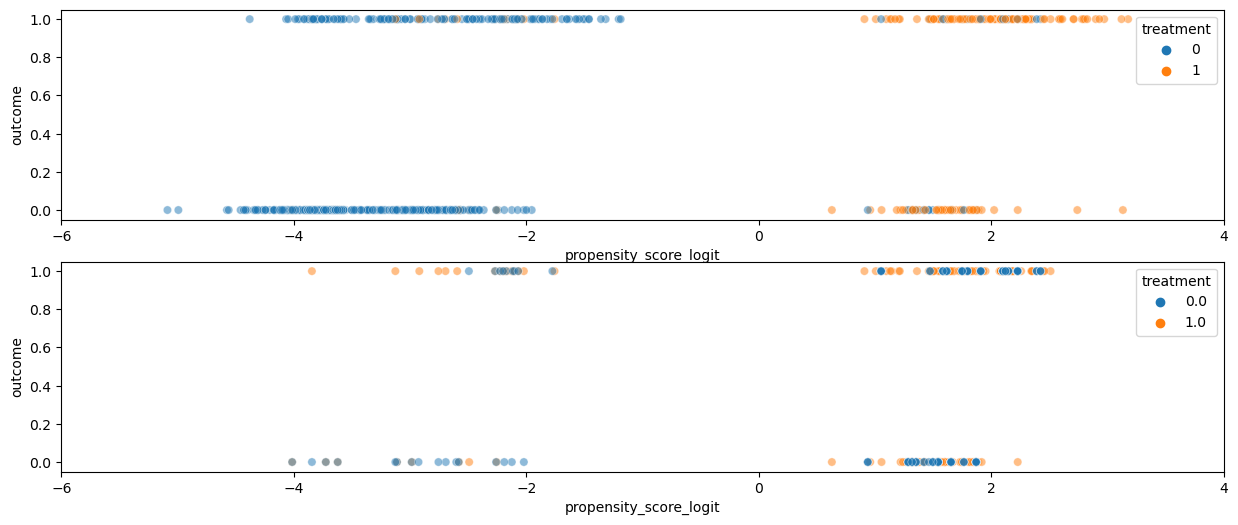

In [69]:
fig, ax = plt.subplots(2, 1, figsize = (15, 6))

sns.scatterplot(
    data = X_encoded, y = 'outcome', x = 'propensity_score_logit', hue = 'treatment', ax = ax[0], alpha = 0.5, 
).set(xlim = (-6, 4))

sns.scatterplot(
    data = all_matched_data, y = 'outcome', x = 'propensity_score_logit', hue = 'treatment', ax = ax[1], alpha = 0.5, 
).set(xlim = (-6, 4))




In [78]:
X_encoded.head()

,Age,SibSp,Parch,Fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,class_1,class_2,class_3,propensity_score,propensity_score_logit,outcome,treatment,matched_element
0,-0.527669,0.522511,-0.506787,-0.516380,-0.756138,0.756138,-0.472618,-0.202326,0.534040,-0.590326,-0.566538,1.002813,0.021156,-3.834463,0,0,NaN
1,0.577094,0.522511,-0.506787,0.694046,1.322511,-1.322511,2.115874,-0.202326,-1.872519,1.693979,-0.566538,-0.997195,0.866755,1.872566,1,1,62.0
2,-0.251478,-0.552714,-0.506787,-0.503620,1.322511,-1.322511,-0.472618,-0.202326,0.534040,-0.590326,-0.566538,1.002813,0.039982,-3.178512,1,0,NaN
3,0.369951,0.522511,-0.506787,0.350326,1.322511,-1.322511,-0.472618,-0.202326,0.534040,1.693979,-0.566538,-0.997195,0.895107,2.144005,1,1,306.0
4,0.369951,-0.552714,-0.506787,-0.501257,-0.756138,0.756138,-0.472618,-0.202326,0.534040,-0.590326,-0.566538,1.002813,0.019913,-3.896294,0,0,NaN


/var/folders/fy/lr4pzd1n2v33kjjk7gkbtt5m0000gn/T/ipykernel_14792/3719582799.py:17: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


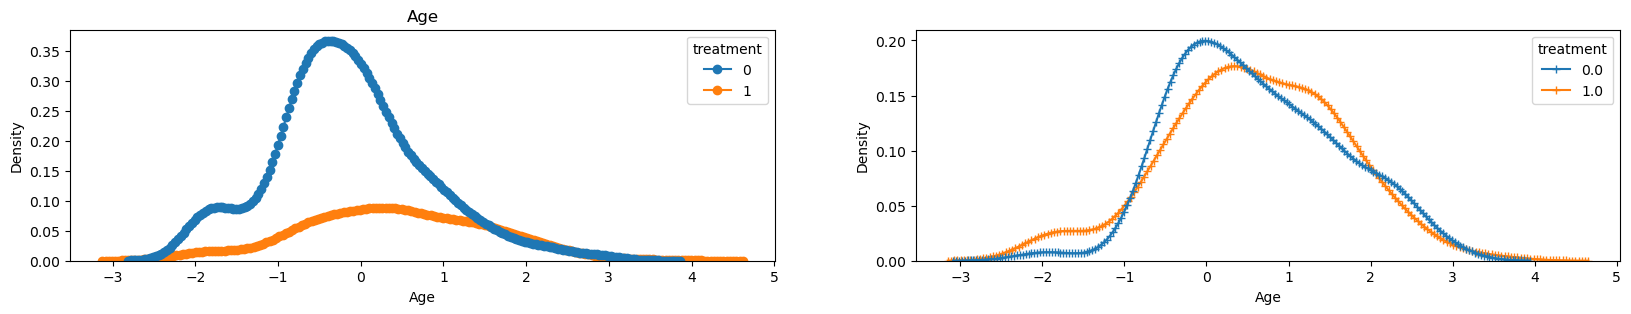

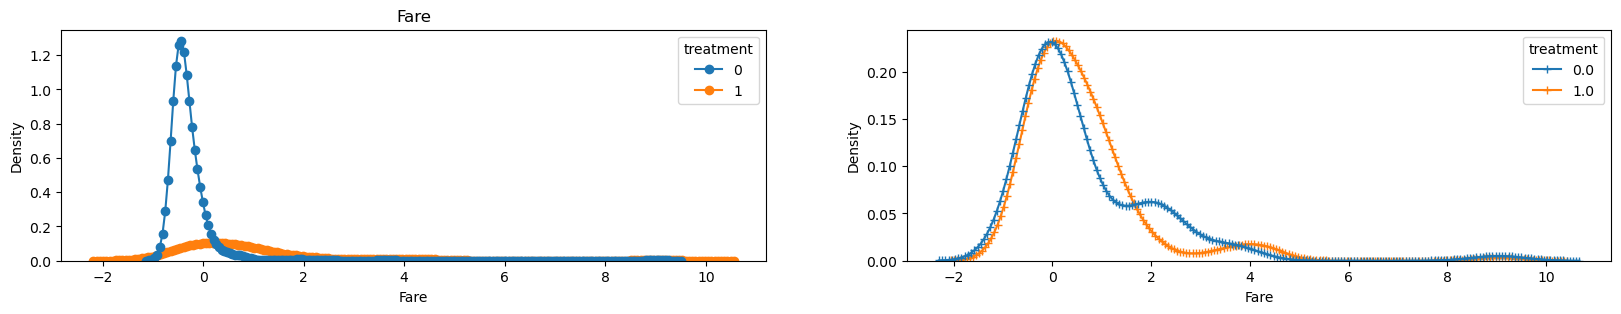

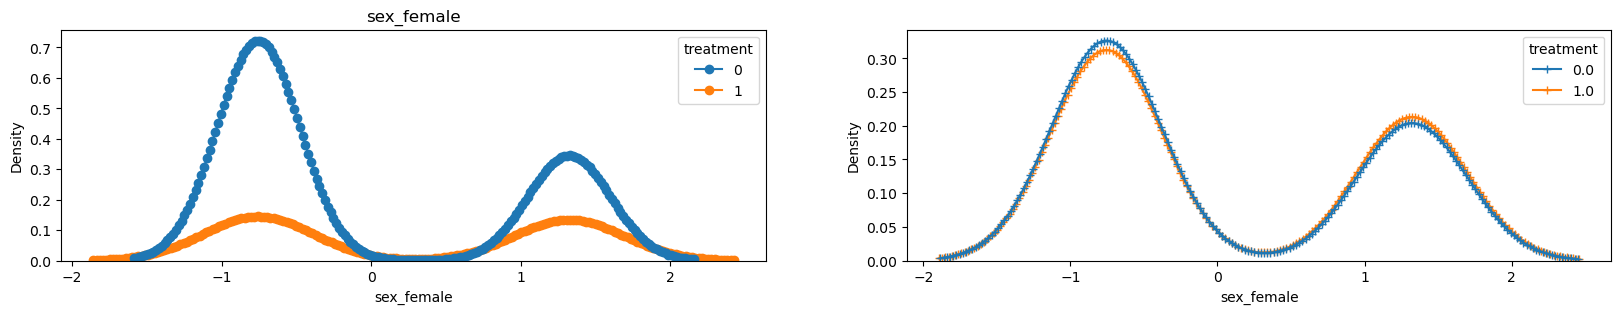

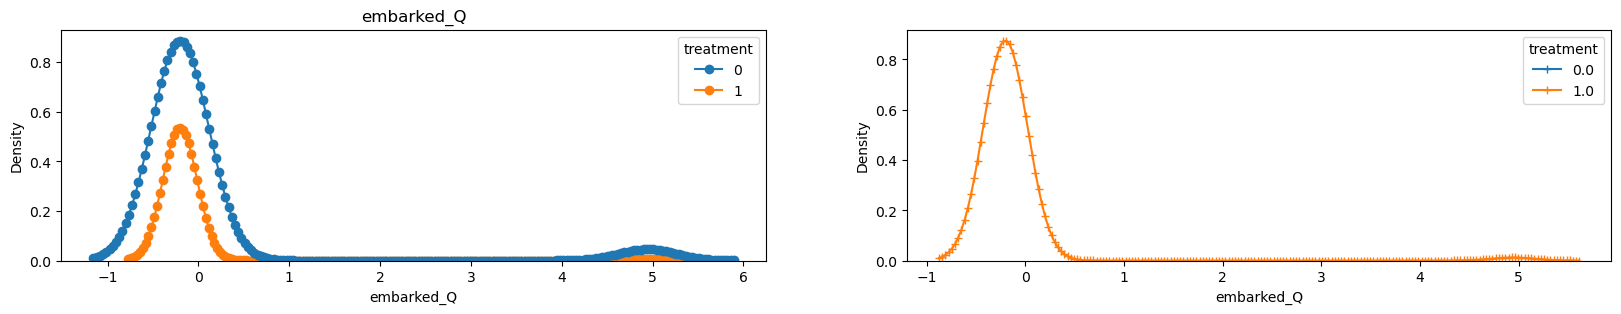

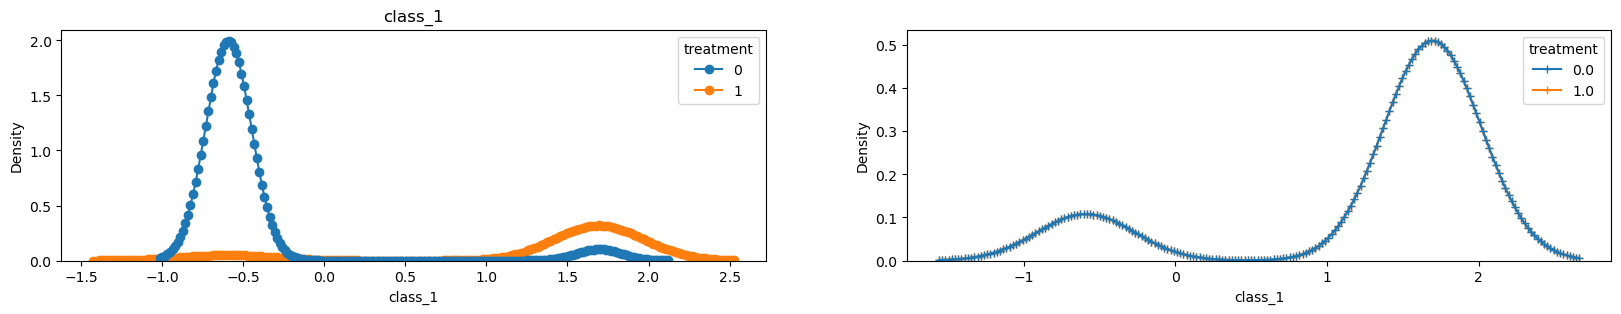

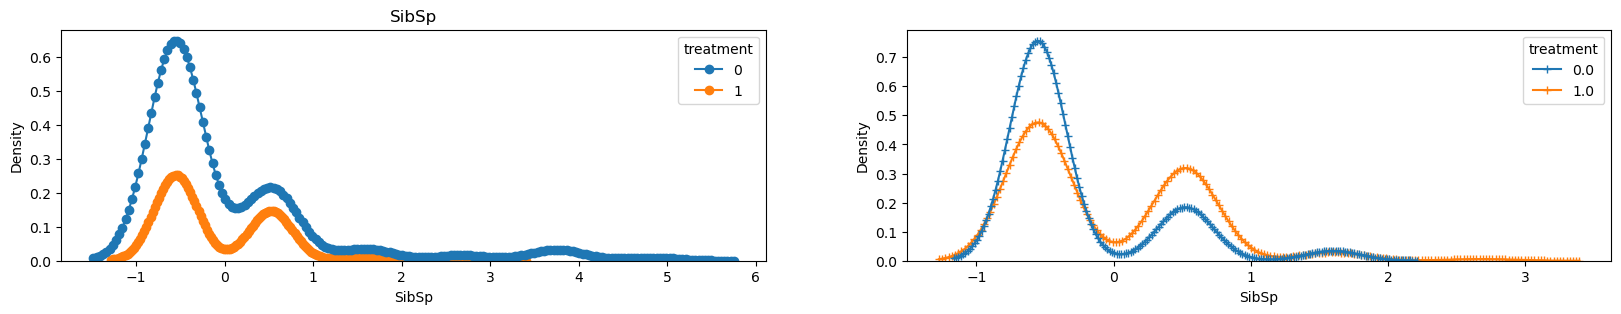

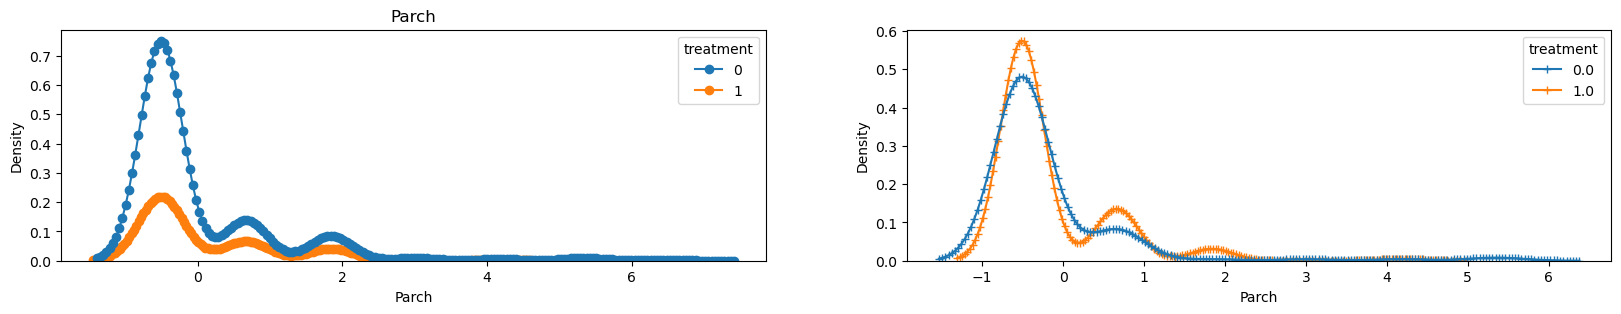

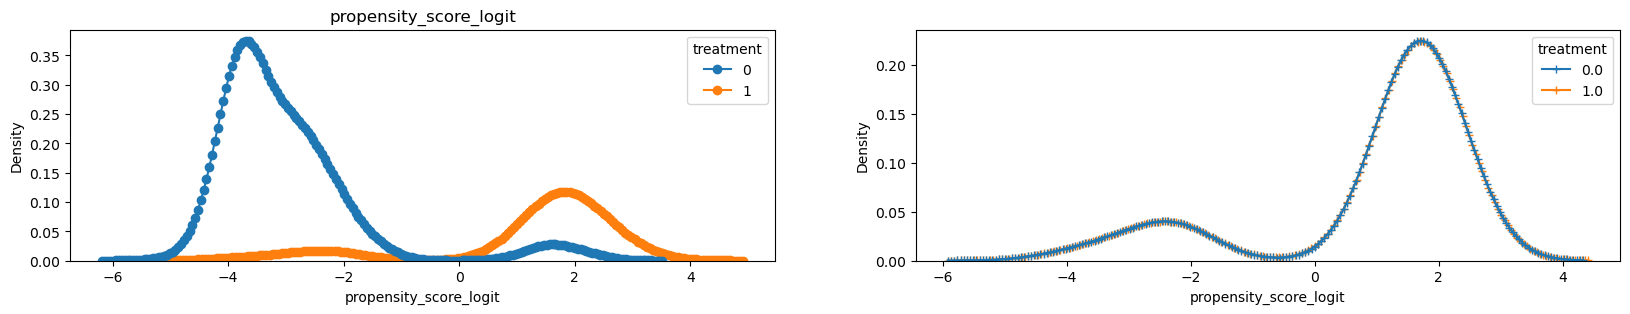

In [80]:
args = [
    'Age',
    'Fare',
    'sex_female',
    'embarked_Q',
    'class_1',
    'SibSp',
    'Parch',
    'propensity_score_logit',
]

def plot(arg):
    fig, ax = plt.subplots(1, 2, figsize = (20, 3))
    sns.kdeplot(
        data = X_encoded, x = arg, hue = 'treatment', ax = ax[0], marker = 'o',
    ).set(title = arg)
    sns.kdeplot(
        data = all_matched_data, x = arg, hue = 'treatment', ax = ax[1], marker = '+',
    )

for arg in args:
    plot(arg)